In [1]:
import pandas as pd
import re
import gensim
import matplotlib
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import numpy as np
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models

In [2]:
def remove_html_tags(text):
    clean_text = re.sub(r'<.*?>|[^\w\s]', '', text)
    return clean_text

In [3]:
warnings.filterwarnings('ignore')

In [55]:
df = pd.read_csv('kbsi_kpa.csv')

In [5]:
text_without_tags = remove_html_tags(df['astrtCont'][1])

In [6]:
df['clean_astrtCont'] = df['astrtCont'].apply(lambda x: remove_html_tags(str(x)))

In [54]:
len(df['clean_astrtCont'])

387

In [30]:
df['clean_astrtCont'][0]

'PURPOSE A probe unit for nuclear magnetic resonance is provided to detect reactions due to environmental changes such as current voltage temperature and fluid speed by detecting chemical reactions generated in a border plane between a fluid and a solidCONSTITUTION A probe unit for nuclear magnetic resonance includes an external conductive body110 a central conductive body140 and a separation film assembly130 The external conductive body has an aperture unit at one end of a long axial direction and a cavity is formed inside of the external conductive body100 The central conductive body is arranged on a central part of the external conductive body and has a first groove which is extended from one end to the other end on an external wall plane along the long axial direction The separation film assembly is closely adhered to the central conductive body to limit a first fluid path which guides a flow of the fluid with the first groove RFRadio Frequency current is applied between the extern

In [7]:
df.columns

Index(['inventionTitle', 'usKind', 'usNo', 'patTpcd', 'applicationNumber',
       'applicationDate', 'publicationDate', 'publicationNumber', 'issueDate',
       'registerNumber', 'registerDate', 'imageStandardCode', 'pubFg',
       'repubFg', 'ipcCd', 'ipcVersion', 'astrtCont', 'applicantName',
       'applicantAddress', 'applicantCountry', 'inventorName', 'receiptNumber',
       'receiptDate', 'documentName', 'documentEngName', 'commonCodeName',
       'clean_astrtCont'],
      dtype='object')

## Title 추출 : 결측치 6개

In [48]:
tokenizer = RegexpTokenizer('[\w]+')
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [49]:
df_title = []

for idx, st in enumerate(df['clean_astrtCont']):
    try:
        df_title.append(st.lower())
    except AttributeError as e:
       continue

In [10]:
df_title = []

for idx, st in enumerate(df['inventionTitle']):
    try:
        df_title.append(st.lower())
    except AttributeError as e:
       continue

## stopwords

In [50]:
user_stopwords = ['for', 'and', 'the', 'method', 'same', 'using', 'capable',
                  'apparatus', 'system', 'with', 'device','having', 'thereof',
                  'first', 'which', 'present', 'one', 'sample', 'kipo', 'are',
                  'from', 'part', 'has', 'long', 'and', 'body', 'hole33', 'rest13', 
                  'probe', 'have', 'without', 'that', 'step', 'relates',
                  '2013', 'provided', 'includes', '2017', '2014', '2012', 'can',
                  'according', 'including', 'providing', 'when', 'thus', '2008', 
                  'end', 'such', 'both', 'apllied', 'due', 'into', 'while', '2015', 'more', 'able', 
                  'not', 'used', 'least', 'than', 'after', 'each']

In [51]:
text = []
sentence = []

for w in df_title:
    try:
        raw = w.lower()
    except AttributeError as e:
        continue
        
    tokens = tokenizer.tokenize(raw)
    
    stopped_tokens = [i for i in tokens if not i in stop_words]
    stemmed_tokens = [lemmatizer.lemmatize(i, pos='n') for i in stopped_tokens]
    stemmed_tokens = [i for i in tokens if (not i in user_stopwords)]
    stemmed_tokens = [i for i in stemmed_tokens if len(i) > 2]
    text.append(stemmed_tokens)
    
dictionary = corpora.Dictionary(text)

corpus = [dictionary.doc2bow(t) for t in text]

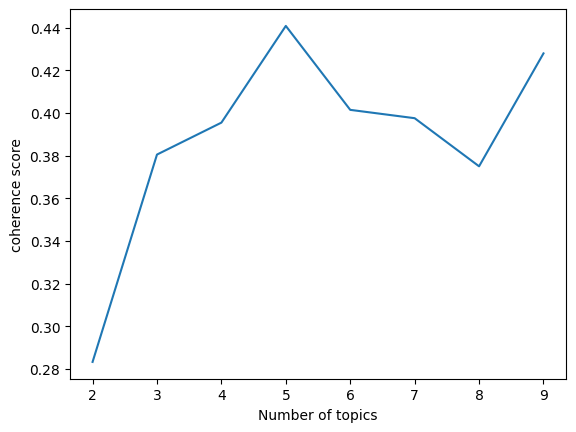

In [13]:
coherence_values = []
for i in range(2, 10):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word=dictionary)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts = text, dictionary=dictionary, topn=10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

x = range(2, 10)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.show()

In [14]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word = dictionary)

In [15]:
ldamodel.print_topics(num_words=10)

[(0,
  '0.019*"plasma" + 0.012*"high" + 0.011*"optical" + 0.008*"manufacturing" + 0.008*"mass" + 0.008*"temperature" + 0.006*"magnetic" + 0.006*"measuring" + 0.006*"magnet" + 0.006*"multi"'),
 (1,
  '0.019*"plasma" + 0.009*"oxide" + 0.008*"electron" + 0.008*"manufacturing" + 0.007*"cable" + 0.007*"generating" + 0.006*"helium" + 0.006*"composition" + 0.006*"microscope" + 0.006*"microwave"'),
 (2,
  '0.011*"manufacturing" + 0.009*"structure" + 0.008*"measuring" + 0.008*"microscope" + 0.007*"gas" + 0.007*"type" + 0.006*"improving" + 0.006*"superconducting" + 0.006*"image" + 0.006*"coil"')]

In [231]:
lda_display = gensimvis.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_display)

## 텍스트 임베딩

In [16]:
model = Word2Vec(sentences=text, vector_size=100, window=5, min_count=1, workers=4)

In [17]:
word_vectors = [model.wv[word] for sentence in text for word in sentence]

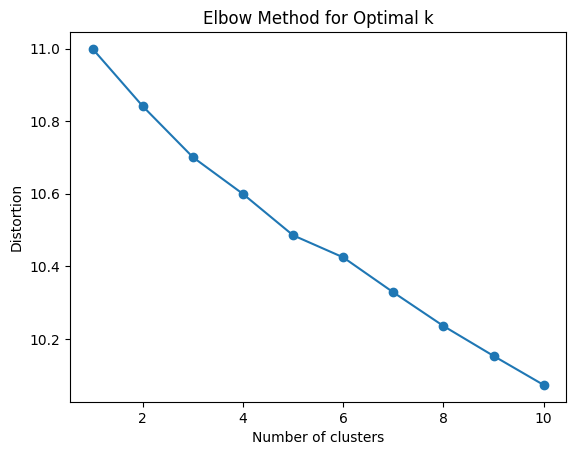

In [18]:
# 적절한 클러스터 개수 찾기
distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(word_vectors)
    distortions.append(kmeans.inertia_)

# 그래프로 나타내기
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal k')
plt.show()

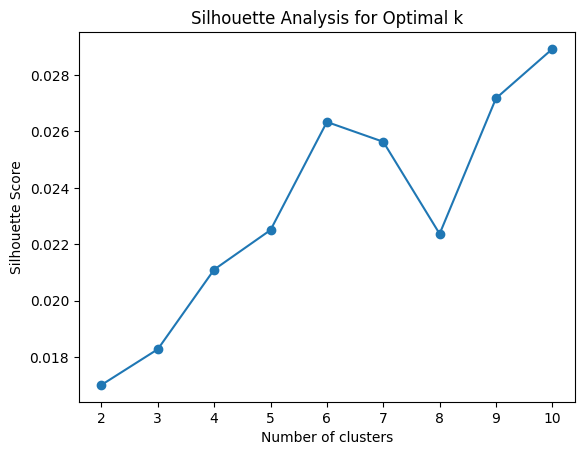

In [19]:
from sklearn.metrics import silhouette_score

# 실루엣 분석
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(word_vectors)
    silhouette_scores.append(silhouette_score(word_vectors, kmeans.labels_))

# 그래프로 나타내기
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

In [20]:
# KMeans 클러스터링
num_clusters = 9  # 클러스터의 개수를 설정
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(word_vectors)

KMeans(n_clusters=9)

In [21]:
# 클러스터링 결과 확인
cluster_labels = kmeans.labels_
clustered_words = {word: label for sentence, label in zip(text, cluster_labels) for word in sentence}

In [22]:
for word, cluster in clustered_words.items():
    print(f"{word}: Cluster {cluster}")

unit: Cluster 4
nuclear: Cluster 2
magnetic: Cluster 4
resonance: Cluster 4
detecting: Cluster 8
characteristics: Cluster 7
fluid: Cluster 2
changed: Cluster 2
according: Cluster 7
time: Cluster 6
plasma: Cluster 1
dry: Cluster 2
reforming: Cluster 7
combining: Cluster 2
wet: Cluster 3
process: Cluster 5
injecting: Cluster 3
stem: Cluster 5
common: Cluster 3
optical: Cluster 5
path: Cluster 2
fiber: Cluster 4
optic: Cluster 3
based: Cluster 2
hand: Cluster 3
held: Cluster 3
parallel: Cluster 5
coherence: Cluster 0
tomography: Cluster 0
manufacturing: Cluster 8
monoatomic: Cluster 5
layer: Cluster 2
black: Cluster 5
phosphorous: Cluster 5
ultrasound: Cluster 5
irradiation: Cluster 5
identity: Cluster 2
base: Cluster 1
efficient: Cluster 1
ring: Cluster 2
signing: Cluster 1
offering: Cluster 1
anonymity: Cluster 1
does: Cluster 1
not: Cluster 1
use: Cluster 5
special: Cluster 1
type: Cluster 5
function: Cluster 5
microwave: Cluster 6
reformer: Cluster 1
stably: Cluster 1
maintaining: Clu

## 네트워크 분석

In [37]:
def tf(t, d):
    return d.count(t)

In [38]:
def generate_co_occurrence_matrix(data):
    
    node = []
    for i in data:
        node.extend(i)
        
    node = list(set(node))
    
    td_matrix = []
    for i in range(len(data)):
        td_matrix.append([])
        d = data[i]
        for j in range(len(node)):
            t = node[j]        
            td_matrix[-1].append(tf(t, d))
    
    tf_ = pd.DataFrame(td_matrix, columns = node)
    tf_=tf_.astype('float')
    column_name = tf_.columns.tolist()
    
    adjacency_matrix = np.dot(tf_.T,tf_)
    cooccurrence_matrix = pd.DataFrame(adjacency_matrix, index = column_name, columns = column_name)
    
    return cooccurrence_matrix

In [52]:
co_occurrence_text = generate_co_occurrence_matrix(text)

In [53]:
co_occurrence_text

,2axis,recovery,nitrogen,xrf,included,adjuster,nanovoids,scattered,interferes,chemical,...,broadcast,region,wiring,device65,disclosed,path,work,welding,magnetron,manufacturing
2axis,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
recovery,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nitrogen,0.0,0.0,58.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,4.0,6.0,2.0,0.0,0.0,11.0
xrf,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
included,0.0,0.0,2.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,11.0,2.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
path,0.0,0.0,6.0,0.0,11.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,70.0,0.0,0.0,0.0,0.0
work,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0
welding,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,740.0,0.0,2.0
magnetron,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0


In [45]:
co_occurrence_text.to_csv('co_occur_abs.csv')